In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [ ]:
train_file_path = "../content/drive/MyDrive/Colab Notebooks/coll_u.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (237362, 97)


In [ ]:
dataset_df.head(3)

,YEAR,CLP,COLL_ID,BUILDING_NAME,PROJECT_ID,PROJECT_NAME,PROVINCE_NAME,DISTICT_NAME,SUBDISTICT_NAME,INTERIOR_SPACE,...,CONVENIENCE_STORE_3KM_SHORTEST,DISCOUNT_STORE_3KM_SHORTEST,DEPARTMENT_STORE_3KM_SHORTEST,GAS_STATION_3KM_SHORTEST,MASS_TRANSIT_3KM_SHORTEST,EDUCATION_3KM_SHORTEST,BANK_3KM_SHORTEST,COFFEE_SHOP_3KM_SHORTEST,PHARMACY_3KM_SHORTEST,GOVERNMENT_OFFICE_3KM_SHORTEST
0,2008,350000,340,อาคารชุดเคหะชุมชนแหลมฉบัง 3,NaN,NaN,ชลบุรี,บางละมุง,บางละมุง,0,...,0.089,0.875,2.409,0.043,0.681,0.079,0.079,0.073,0.802,0.175
1,2010,350000,541,เคหะชุมชนแหลมฉบัง 2,NaN,NaN,ชลบุรี,บางละมุง,บางละมุง,0,...,0.076,0.261,0.000,0.438,0.539,0.047,0.077,0.064,0.694,0.152
2,2008,350000,222,นิรันดร์ แกรนด์ วิลล์,NaN,NaN,ชลบุรี,บางละมุง,หนองปรือ,0,...,0.332,0.617,1.028,0.649,0.000,0.492,0.477,0.471,0.588,0.554


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237362 entries, 0 to 237361
Data columns (total 97 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   YEAR                            237362 non-null  int64  
 1   CLP                             237362 non-null  int64  
 2   COLL_ID                         237362 non-null  int64  
 3   BUILDING_NAME                   237361 non-null  object 
 4   PROJECT_ID                      163960 non-null  object 
 5   PROJECT_NAME                    165884 non-null  object 
 6   PROVINCE_NAME                   237362 non-null  object 
 7   DISTICT_NAME                    237361 non-null  object 
 8   SUBDISTICT_NAME                 236828 non-null  object 
 9   INTERIOR_SPACE                  237362 non-null  int64  
 10  FIRE_INSUR_AREA                 237362 non-null  int64  
 11  BUILDING_AREA                   237362 non-null  float64
 12  OUTSIDE_LIVING_S

In [ ]:
dataset_df.drop([
        'COLL_ID','BUILDING_NAME','PROJECT_ID','PROJECT_NAME','SUBDISTICT_NAME','STREET','SOI'
],
             axis=1,
             inplace=True)

In [ ]:
df_new = dataset_df[(dataset_df['PROVINCE_NAME'] == 'กรุงเทพมหานคร') & (dataset_df['NO_OF_FLOOR'] >= 7)]

In [ ]:
df_new.shape

(75574, 90)

In [ ]:
indices_to_drop = df_new[df_new['NO_OF_FLOOR'] > 60].index
df_new = df_new.drop(indices_to_drop)

In [ ]:
df_new.shape

(75536, 90)

In [ ]:
df_new = df_new[['LIFT',
'FIRE_INSUR_AREA',
'BUILDING_CONDITION_DESC',
'BUILDING_AREA',
'NO_OF_FLOOR',
'GARDEN',
'POOL',
'BUILDING_AGE',
'DISTICT_NAME',
'STEAM_ROOM',
'EXERCISE_ROOM',
'CLP']]

In [ ]:
# Check for null values in each column
null_counts = df_new.isnull().sum()

# Sort the null_counts Series in descending order
sorted_null_counts = null_counts.sort_values(ascending=False)

# Display the column names and null counts in descending order
print("Column names and null counts in descending order:")
for column, null_count in sorted_null_counts.items():
    print(f"{column}: {null_count}")

Column names and null counts in descending order:
STEAM_ROOM: 24206
GARDEN: 22157
EXERCISE_ROOM: 21518
POOL: 21494
LIFT: 19803
BUILDING_CONDITION_DESC: 48
FIRE_INSUR_AREA: 0
BUILDING_AREA: 0
NO_OF_FLOOR: 0
BUILDING_AGE: 0
DISTICT_NAME: 0
CLP: 0


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75536 entries, 5 to 237358
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LIFT                     55733 non-null  object 
 1   FIRE_INSUR_AREA          75536 non-null  int64  
 2   BUILDING_CONDITION_DESC  75488 non-null  object 
 3   BUILDING_AREA            75536 non-null  float64
 4   NO_OF_FLOOR              75536 non-null  int64  
 5   GARDEN                   53379 non-null  object 
 6   POOL                     54042 non-null  object 
 7   BUILDING_AGE             75536 non-null  int64  
 8   DISTICT_NAME             75536 non-null  object 
 9   STEAM_ROOM               51330 non-null  object 
 10  EXERCISE_ROOM            54018 non-null  object 
 11  CLP                      75536 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 7.5+ MB


In [ ]:
# Check for null values in each column
null_counts = df_new.isnull().sum()

# Sort the null_counts Series in descending order
sorted_null_counts = null_counts.sort_values()

# Display the column names and null counts in descending order
print("Column names and null counts in descending order:")
for column, null_count in sorted_null_counts.items():
    print(f"{column}: {null_count}")

Column names and null counts in descending order:
FIRE_INSUR_AREA: 0
BUILDING_AREA: 0
NO_OF_FLOOR: 0
BUILDING_AGE: 0
DISTICT_NAME: 0
CLP: 0
BUILDING_CONDITION_DESC: 48
LIFT: 19803
POOL: 21494
EXERCISE_ROOM: 21518
GARDEN: 22157
STEAM_ROOM: 24206


In [ ]:
df_new['BUILDING_CONDITION_DESC'].fillna('ธรรมดา', inplace=True)
df_new['STEAM_ROOM'].fillna('N', inplace=True)
df_new['LIFT'].fillna('N', inplace=True)
df_new['EXERCISE_ROOM'].fillna('N', inplace=True)
df_new['GARDEN'].fillna('N', inplace=True)
df_new['POOL'].fillna('N', inplace=True)


In [ ]:
# Check for null values in each column
null_counts = df_new.isnull().sum()

# Sort the null_counts Series in descending order
sorted_null_counts = null_counts.sort_values()

# Display the column names and null counts in descending order
print("Column names and null counts in descending order:")
for column, null_count in sorted_null_counts.items():
    print(f"{column}: {null_count}")

Column names and null counts in descending order:
LIFT: 0
FIRE_INSUR_AREA: 0
BUILDING_CONDITION_DESC: 0
BUILDING_AREA: 0
NO_OF_FLOOR: 0
GARDEN: 0
POOL: 0
BUILDING_AGE: 0
DISTICT_NAME: 0
STEAM_ROOM: 0
EXERCISE_ROOM: 0
CLP: 0


In [ ]:
list(set(df_new.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

s = (df_new.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
      len(object_cols))

Categorical variables:
['LIFT', 'BUILDING_CONDITION_DESC', 'GARDEN', 'POOL', 'DISTICT_NAME', 'STEAM_ROOM', 'EXERCISE_ROOM']
No. of. categorical features:  7


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming dataset_df and object_cols are defined
OH_encoder = OneHotEncoder(sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_new[object_cols]))
OH_cols.index = df_new.index
OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)

df_final = df_new.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)


In [ ]:
print("Full train dataset shape is {}".format(df_final.shape))

Full train dataset shape is (75536, 173)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [ ]:
# Importing required libraries
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming df_final is your DataFrame with features and target variable CLP
# Splitting the data into features (X) and target variable (y)
X = df_final.drop('CLP', axis=1)  # Features
y = df_final['CLP']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the XGBoost Regressor
xgb_regressor = XGBRegressor(random_state=42)

# Fit the model to the training data
xgb_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_regressor.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 20.05675158481682


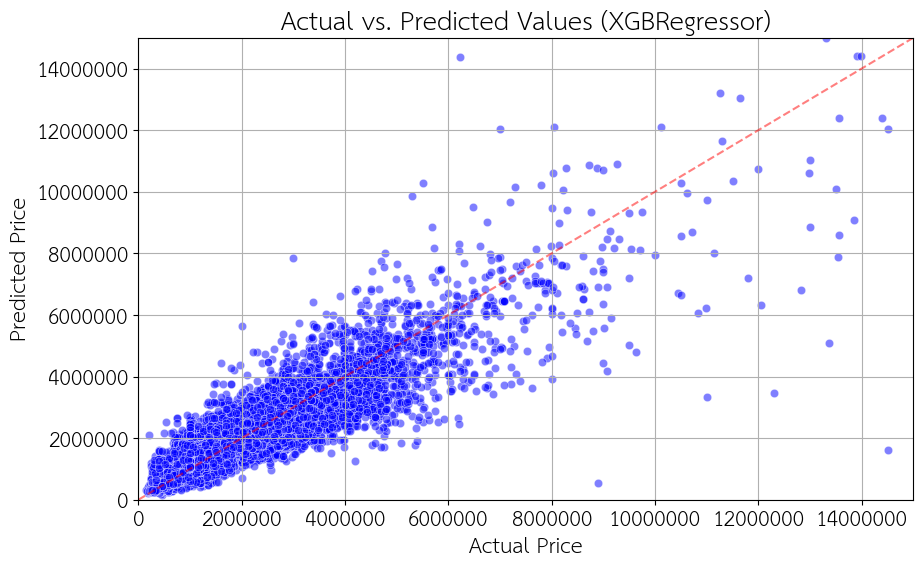

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot scatter plot of actual vs predicted values
def plot_scatter(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted, color='blue', alpha=0.5)
    plt.title(f'Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.xlim(0, 15000000)  # Set x-axis limits from 0 to 15,000,000
    plt.ylim(0, 15000000)  # Set y-axis limits from 0 to 15,000,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.plot([0, 15000000], [0, 15000000], color='red', linestyle='--', alpha=0.5)  # Add diagonal line for perfect predictions
    plt.grid(True)
    plt.show()

# Plot scatter plot for each model
models = [xgb_regressor]  # Add other models if you have trained them
model_names = ['XGBRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_scatter(y_test, predictions, model_name)

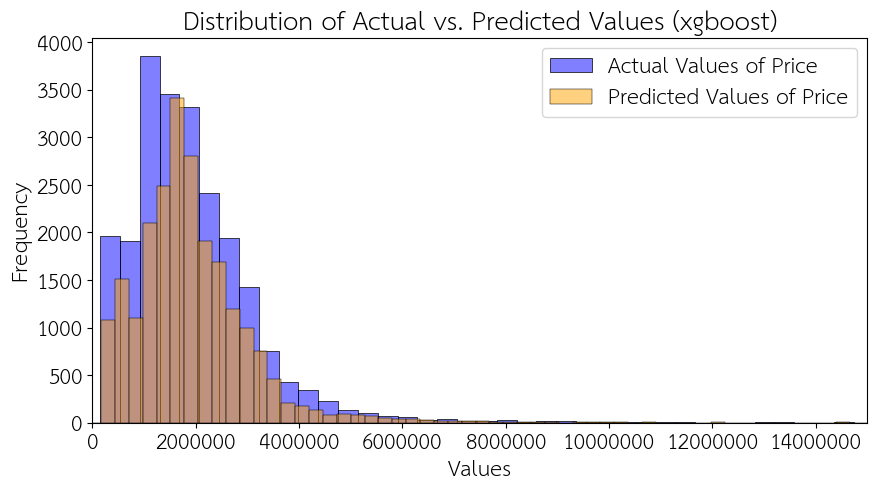

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions of actual and predicted values
def plot_distributions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    sns.histplot(actual, bins=100, color='blue', alpha=0.5, label='Actual Values of Price')
    sns.histplot(predicted, bins=100, color='orange', alpha=0.5, label='Predicted Values of Price')
    plt.legend()
    plt.title(f'Distribution of Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.ylim(0, )  # Set y-axis limits from 0 to 1,000,000
    plt.xlim(0, 15000000)  # Set x-axis limits from 0 to 1,500,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.show()

# Plot distributions for each model
models = [xgb_regressor]  # Add other models if you have trained them
model_names = ['xgboost']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_distributions(y_test, predictions, model_name)




In [ ]:
import matplotlib as mpl

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [ ]:
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New', size= 15)

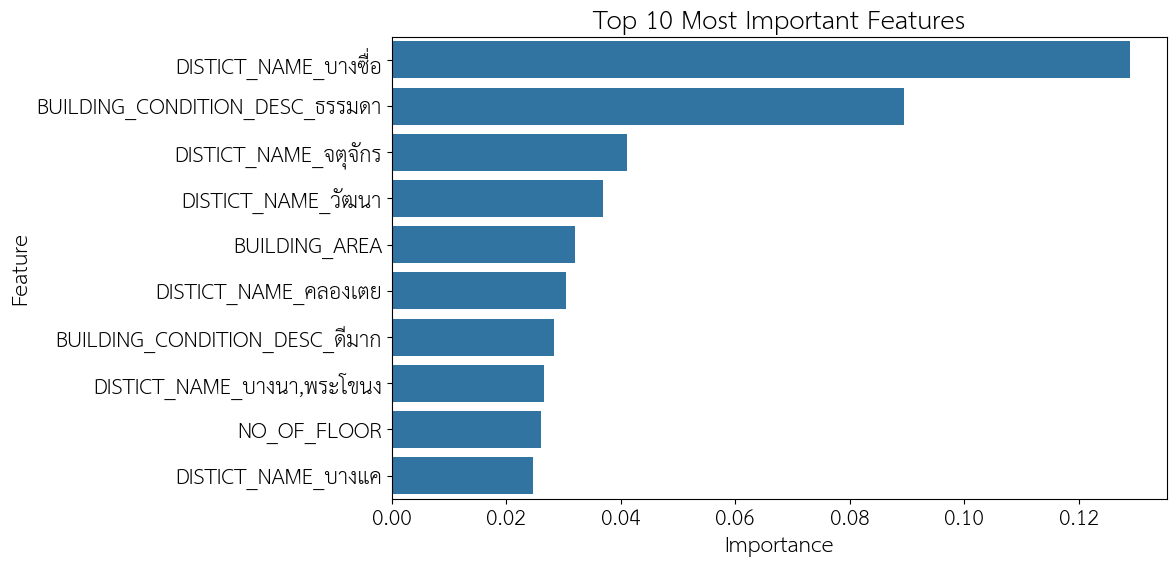

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'xgb' is your XGBoost model
feature_importances = xgb_regressor.feature_importances_

# Get the names of the features
feature_names = X_test.columns  # Assuming X_test is a pandas DataFrame

# Create a DataFrame with feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))  # Plotting top 10 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming df_final is your DataFrame with features and target variable CLP
# Splitting the data into features (X) and target variable (y)
X = df_final.drop('CLP', axis=1)  # Features
y = df_final['CLP']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the KNN Regressor
knn_regressor = KNeighborsRegressor()

# Fit the model to the training data
knn_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = knn_regressor.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 15.71532258279696


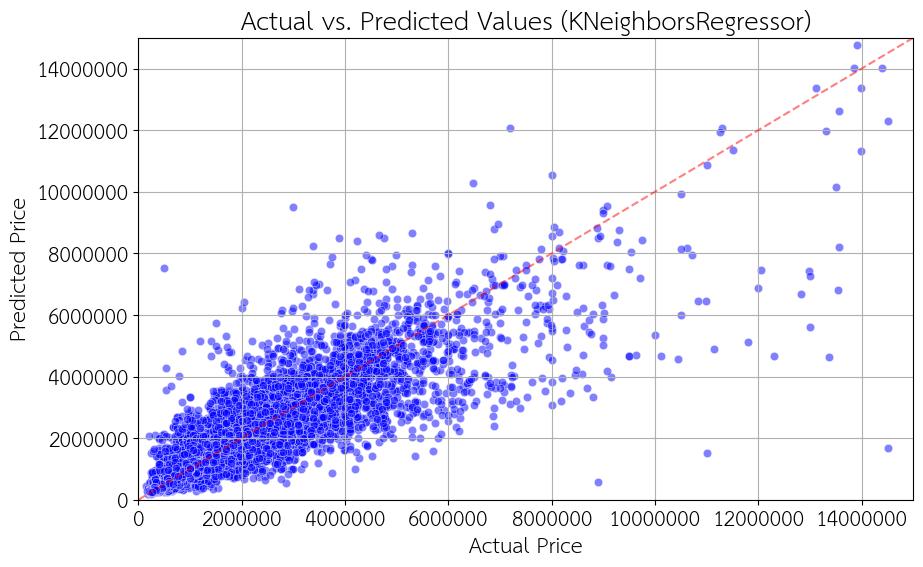

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot scatter plot of actual vs predicted values
def plot_scatter(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted, color='blue', alpha=0.5)
    plt.title(f'Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.xlim(0, 15000000)  # Set x-axis limits from 0 to 15,000,000
    plt.ylim(0, 15000000)  # Set y-axis limits from 0 to 15,000,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.plot([0, 15000000], [0, 15000000], color='red', linestyle='--', alpha=0.5)  # Add diagonal line for perfect predictions
    plt.grid(True)
    plt.show()

# Plot scatter plot for each model
models = [knn_regressor]  # Add other models if you have trained them
model_names = ['KNeighborsRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_scatter(y_test, predictions, model_name)

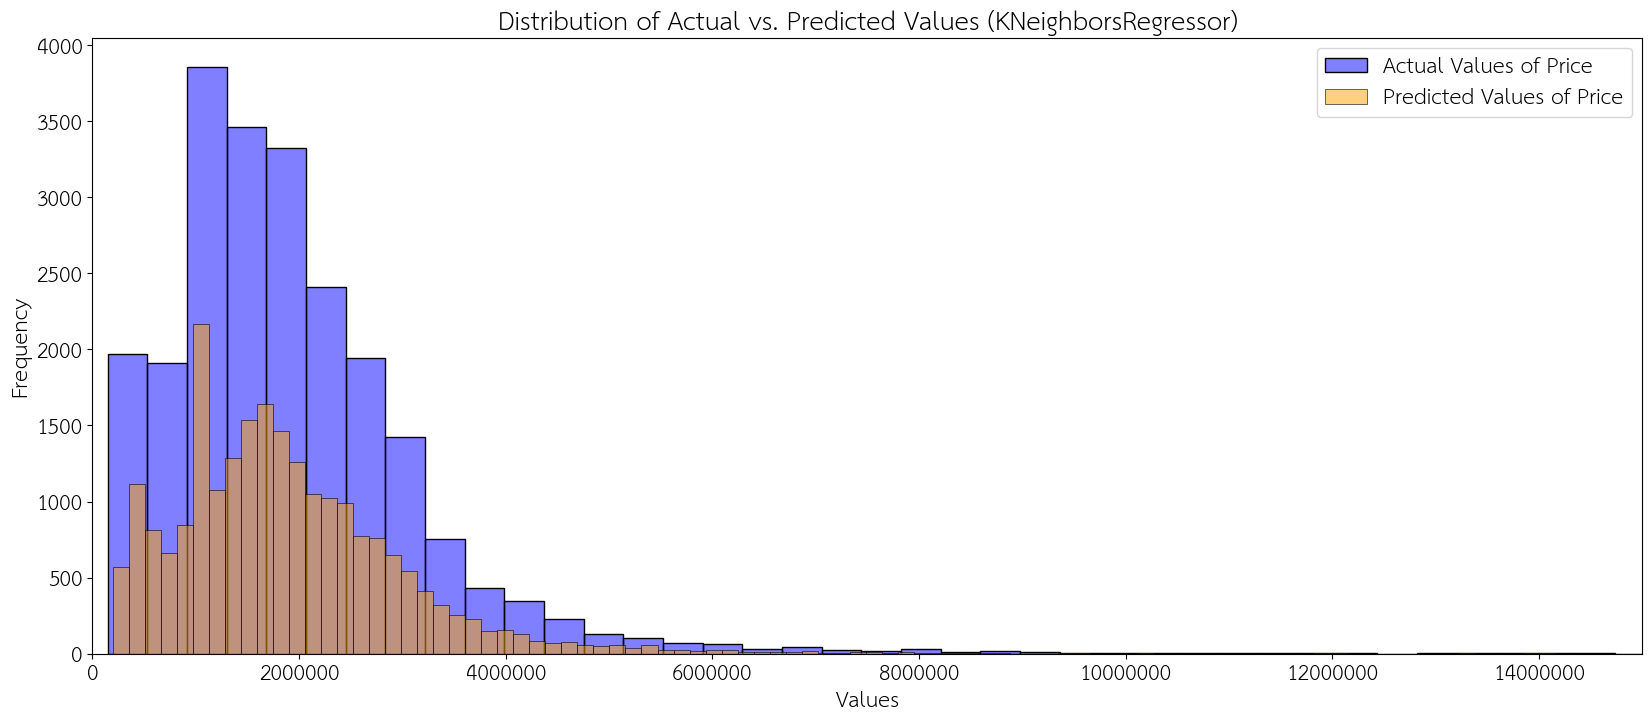

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions of actual and predicted values
def plot_distributions(actual, predicted, model_name):
    plt.figure(figsize=(20, 8))
    sns.histplot(actual, bins=100, color='blue', alpha=0.5, label='Actual Values of Price')
    sns.histplot(predicted, bins=100, color='orange', alpha=0.5, label='Predicted Values of Price')
    plt.legend()
    plt.title(f'Distribution of Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.ylim(0, )  # Set y-axis limits from 0 to 1,000,000
    plt.xlim(0, 15000000)  # Set x-axis limits from 0 to 1,500,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.show()

# Plot distributions for each model
models = [knn_regressor]  # Add other models if you have trained them
model_names = ['KNeighborsRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_distributions(y_test, predictions, model_name)




In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Assuming df_final is your DataFrame with features and target variable CLP
# Splitting the data into features (X) and target variable (y)
X = df_final.drop('CLP', axis=1)  # Features
y = df_final['CLP']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the Extra Trees Regressor
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
extra_trees.fit(X_train, y_train)

# Predict on the test data
y_pred = extra_trees.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Absolute Percentage Error (MAPE): 12.14%


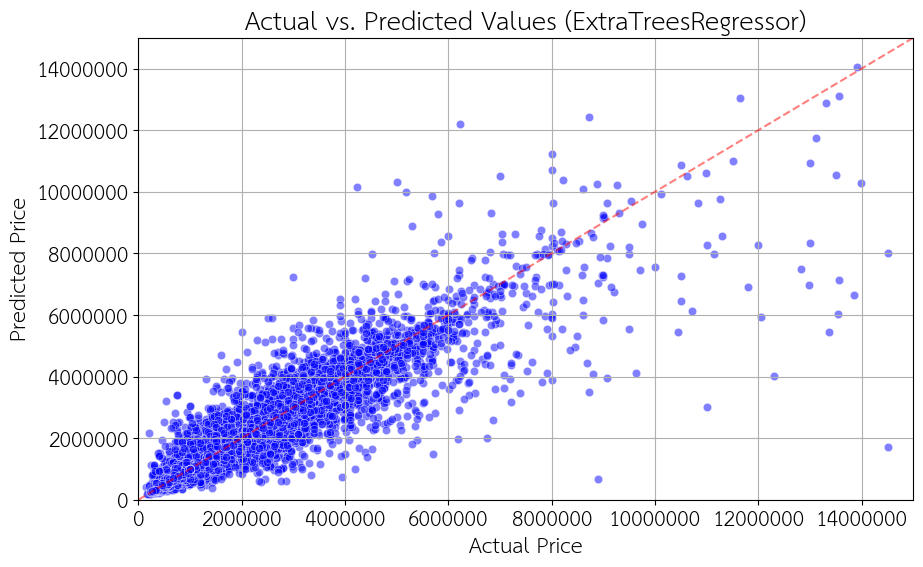

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot scatter plot of actual vs predicted values
def plot_scatter(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted, color='blue', alpha=0.5)
    plt.title(f'Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.xlim(0, 15000000)  # Set x-axis limits from 0 to 15,000,000
    plt.ylim(0, 15000000)  # Set y-axis limits from 0 to 15,000,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.plot([0, 15000000], [0, 15000000], color='red', linestyle='--', alpha=0.5)  # Add diagonal line for perfect predictions
    plt.grid(True)
    plt.show()

# Plot scatter plot for each model
models = [extra_trees]  # Add other models if you have trained them
model_names = ['ExtraTreesRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_scatter(y_test, predictions, model_name)

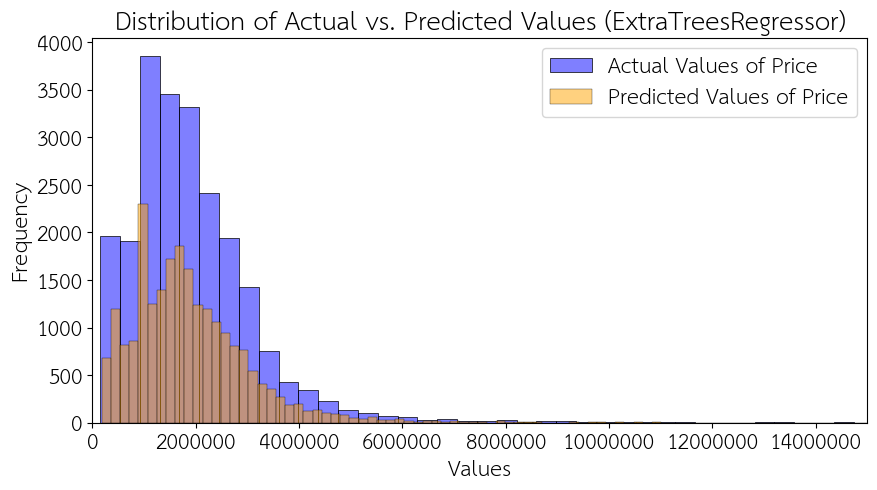

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions of actual and predicted values
def plot_distributions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    sns.histplot(actual, bins=100, color='blue', alpha=0.5, label='Actual Values of Price')
    sns.histplot(predicted, bins=100, color='orange', alpha=0.5, label='Predicted Values of Price')
    plt.legend()
    plt.title(f'Distribution of Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.ylim(0, )  # Set y-axis limits from 0 to 1,000,000
    plt.xlim(0, 15000000)  # Set x-axis limits from 0 to 1,500,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.show()

# Plot distributions for each model
models = [extra_trees]  # Add other models if you have trained them
model_names = ['ExtraTreesRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_distributions(y_test, predictions, model_name)


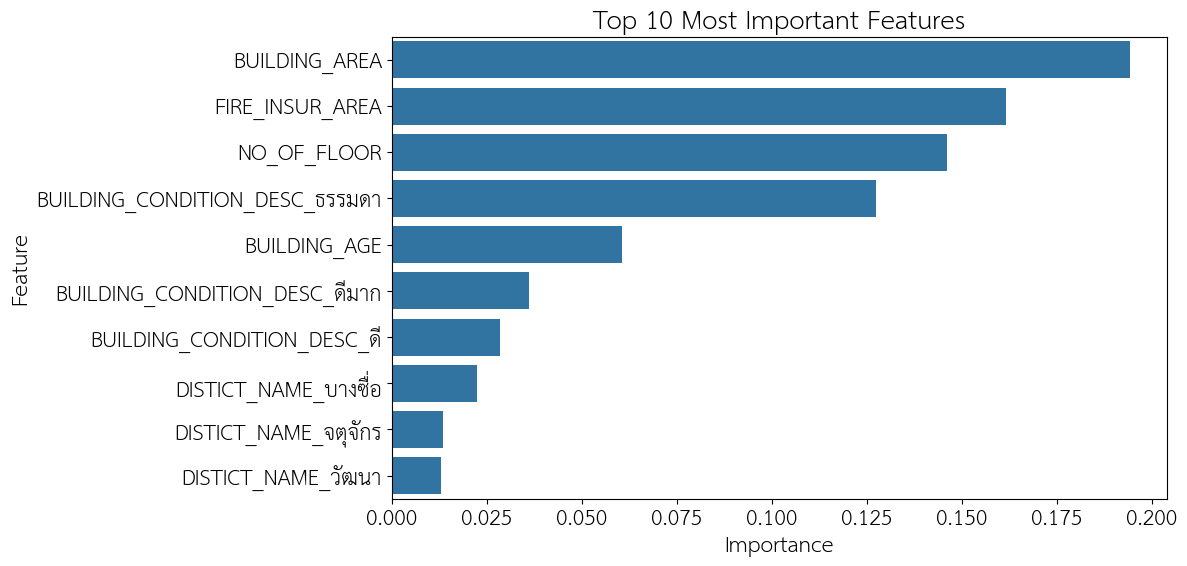

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
feature_importances = extra_trees.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame

# Create a DataFrame with feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))  # Plotting top 10 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()
